In [1]:
import sys
import argparse
import cv2
import yaml
import numpy as np
from os import listdir
from os.path import isfile, join
import os
from copy import deepcopy

from FaceBoxes import FaceBoxes
from TDDFA import TDDFA
from utils.render import render
#from utils.render_ctypes import render  # faster
from utils.depth import depth
from utils.pncc import pncc
from utils.uv import uv_tex
from utils.pose import viz_pose, viz_pose_1
from utils.serialization import ser_to_ply, ser_to_obj
from utils.functions import draw_landmarks, get_suffix
from utils.tddfa_util import str2bool

/home/uss00067/anaconda3/envs/facial/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
is_debug = False
def detect_attributes(img, args):
    """
    Detect facial attributes of the given images, including 2/3D landmarks, head pose, depth, etc
    See this for more details: https://github.com/cleardusk/3DDFA_V2
    """
    cfg = yaml.load(open(args.config), Loader=yaml.SafeLoader)

    # Init FaceBoxes and TDDFA, recommend using onnx flag
    if args.onnx:
        import os
        os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
        os.environ['OMP_NUM_THREADS'] = '4'

        from FaceBoxes.FaceBoxes_ONNX import FaceBoxes_ONNX
        from TDDFA_ONNX import TDDFA_ONNX

        face_boxes = FaceBoxes_ONNX()
        tddfa = TDDFA_ONNX(**cfg)
    else:
        gpu_mode = args.mode == 'gpu'
        tddfa = TDDFA(gpu_mode=gpu_mode, **cfg)
        face_boxes = FaceBoxes()

    # Detect faces, get 3DMM params and roi boxes
    boxes = face_boxes(img)
    n = len(boxes)
    if n == 0:
        print(f'No face detected, exit')
        sys.exit(-1)

    param_lst, roi_box_lst = tddfa(img, boxes)

    # Visualization and serialization
    dense_flag = args.opt in ('2d_dense', '3d', 'depth', 'pncc', 'uv_tex', 'ply', 'obj')
    
    ver_lst = tddfa.recon_vers(param_lst, roi_box_lst, dense_flag=dense_flag)

    if is_debug:
        print('ver_lst: ', ver_lst)

    # Only return 2D landmarks
    return ver_lst[0]

def detect_face(img, landmark_raw):
    """
    Crop face area according to the detected landmarks
    """
    # This size must ensure the face part is not missing, otherwise, the landmark detection will generate negative coordinates
    # img_size = 1000 # Hyperparam 1000 for video_001
    v_size = 1000
    u_size = 900
    if is_debug:
        print('In detect_face, shape of input img: ', img.shape)

    u_coords = landmark_raw[0,:]
    v_coords = landmark_raw[1,:]
    u_max = int(np.max(u_coords))
    u_min = int(np.min(u_coords))
    v_max = int(np.max(v_coords))
    v_min = int(np.min(v_coords))

    middle_u = int((u_max+u_min)/2)
    middle_v = int((v_max+v_min)/2)
    
    new_u_max = middle_u + int(u_size/2)
    new_u_min = middle_u - int(u_size/2)
    new_v_max = middle_v + int(v_size/2)
    new_v_min = middle_v - int(v_size/2)
    
    if new_u_max < 0 or new_u_min < 0 or new_v_max < 0 or new_v_min < 0:
        print('Index: ', new_u_max, new_u_min, new_v_max, new_v_min)
        raise RuntimeError('Index is negative!')

    new_img = img[new_v_min:new_v_max, new_u_min:new_u_max, :]
    return new_img
    
def split_face(landmark_raw):
    """
    Crop left eyes, right eyes, and mouth from the given image
    """

    left_eyebrow = np.hstack((landmark_raw[0, 17:22][:, np.newaxis], landmark_raw[1, 17:22][:, np.newaxis]))
    if is_debug:
        print('Left eyebrow: ', left_eyebrow)

    right_eyebrow = np.hstack((landmark_raw[0, 22:27][:, np.newaxis], landmark_raw[1, 22:27][:, np.newaxis]))
    if is_debug:
        print('Right eyebrow: ', right_eyebrow)

    left_eye = np.hstack((landmark_raw[0, 36:42][:, np.newaxis], landmark_raw[1, 36:42][:, np.newaxis]))
    if is_debug:
        print('Left eye: ', left_eye)

    right_eye = np.hstack((landmark_raw[0, 42:48][:, np.newaxis], landmark_raw[1, 42:48][:, np.newaxis]))
    if is_debug:
        print('Right eye: ', right_eye)

    mouth = np.hstack((landmark_raw[0, 48:68][:, np.newaxis], landmark_raw[1, 48:68][:, np.newaxis]))
    if is_debug:
        print('Mouth: ', mouth)

    left = np.vstack((left_eyebrow, left_eye))
    if is_debug:
        print('Left part: ', left)

    right = np.vstack((right_eyebrow, right_eye))
    if is_debug:
        print('Right part: ', right)

    # Right part if the image itself = Left part of the third-person view
    right_u_max = int(np.max(left[:, 0])) 
    right_u_min = int(np.min(left[:, 0]))
    right_v_max = int(np.max(left[:, 1]))
    right_v_min = int(np.min(left[:, 1]))

    # Left part if the image itself = Right part of the third-person view
    left_u_max = int(np.max(right[:, 0]))
    left_u_min = int(np.min(right[:, 0]))
    left_v_max = int(np.max(right[:, 1]))
    left_v_min = int(np.min(right[:, 1]))

    if is_debug:
        print('Left u max: ', left_u_max)
        print('Left u min: ', left_u_min)
        print('Left v max: ', left_v_max)
        print('Left v min: ', left_v_min)

    
    if is_debug:
        print('Right u max: ', right_u_max)
        print('Right u min: ', right_u_min)
        print('Right v max: ', right_v_max)
        print('Right v min: ', right_v_min)

    mouth_u_max = int(np.max(mouth[:, 0]))
    mouth_u_min = int(np.min(mouth[:, 0]))
    mouth_v_max = int(np.max(mouth[:, 1]))
    mouth_v_min = int(np.min(mouth[:, 1]))
    if is_debug:
        print('Mouth u max: ', mouth_u_max)
        print('Mouth u min: ', mouth_u_min)
        print('Mouth v max: ', mouth_v_max)
        print('Mouth v min: ', mouth_v_min)

    left_coords = [left_v_max, left_v_min, left_u_max, left_u_min]
    right_coords = [right_v_max, right_v_min, right_u_max, right_u_min]
    mouth_coords = [mouth_v_max, mouth_v_min, mouth_u_max, mouth_u_min]

    split_data = {
        'left_coords':left_coords,
        'right_coords':right_coords,
        'mouth_coords':mouth_coords
    }
    return split_data

In [24]:
from copy import deepcopy
import matplotlib.pyplot as plt

def main(args):
    target_img_path = '/home/uss00067/Datasets/00000/00992.png'
    ref_img_path = '/home/uss00067/Datasets/00000/00987.png'
    target_img = cv2.imread(target_img_path)
    print('tgt image shape: ', target_img.shape)

    ref_img = cv2.imread(ref_img_path)
    print('ref image shape: ', ref_img.shape)
    
    overlaid_img = deepcopy(ref_img)
    
    ref_img_2d_landmarks = detect_attributes(ref_img, args)
    target_img_2d_landmarks = detect_attributes(target_img, args)
    
    ref_split_data = split_face(ref_img_2d_landmarks)
    target_split_data = split_face(target_img_2d_landmarks)
    
    ref_left_coords = ref_split_data['left_coords']
    ref_left_v_mean, ref_left_u_mean = int((ref_left_coords[0]+ref_left_coords[1])/2), int((ref_left_coords[2]+ref_left_coords[3])/2)

    ref_right_coords = ref_split_data['right_coords']
    ref_right_v_mean, ref_right_u_mean = int((ref_right_coords[0]+ref_right_coords[1])/2), int((ref_right_coords[2]+ref_right_coords[3])/2)

    ref_mouth_coords = ref_split_data['mouth_coords']
    ref_mouth_v_mean, ref_mouth_u_mean = int((ref_mouth_coords[0]+ref_mouth_coords[1])/2), int((ref_mouth_coords[2]+ref_mouth_coords[3])/2)
    
    target_left_coords = target_split_data['left_coords']
    target_right_coords = target_split_data['right_coords']
    target_mouth_coords = target_split_data['mouth_coords']
    
    delta = 30
    
#     # Extract left part
#     target_left_rgb = target_img[target_left_coords[1]-delta:target_left_coords[0]+delta, target_left_coords[3]-delta:target_left_coords[2]+delta]
#     target_left_v_range = target_left_rgb.shape[0]
#     target_left_u_range = target_left_rgb.shape[1]

#     target_left_v_min = ref_left_v_mean - int(target_left_v_range/2)
#     target_left_v_max = target_left_v_min + target_left_v_range
#     target_left_u_min = ref_left_u_mean - int(target_left_u_range/2)
#     target_left_u_max = target_left_u_min + target_left_u_range
    
#     overlaid_img[target_left_v_min:target_left_v_max, target_left_u_min:target_left_u_max, :] = target_left_rgb
    
#     # Extract right part
#     target_right_rgb = target_img[target_right_coords[1]-delta:target_right_coords[0]+delta, target_right_coords[3]-delta:target_right_coords[2]+delta]
#     target_right_v_range = target_right_rgb.shape[0]
#     target_right_u_range = target_right_rgb.shape[1]

#     target_right_v_min = ref_right_v_mean - int(target_right_v_range/2)
#     target_right_v_max = target_right_v_min + target_right_v_range
#     target_right_u_min = ref_right_u_mean - int(target_right_u_range/2)
#     target_right_u_max = target_right_u_min + target_right_u_range
    
#     overlaid_img[target_right_v_min:target_right_v_max, target_right_u_min:target_right_u_max, :] = target_right_rgb
    
    # Extract mouth part
    target_mouth_rgb = target_img[target_mouth_coords[1]-delta:target_mouth_coords[0]+delta, target_mouth_coords[3]-delta:target_mouth_coords[2]+delta]
    target_mouth_v_range = target_mouth_rgb.shape[0]
    target_mouth_u_range = target_mouth_rgb.shape[1]

    target_mouth_v_min = ref_mouth_v_mean - int(target_mouth_v_range/2)
    target_mouth_v_max = target_mouth_v_min + target_mouth_v_range
    target_mouth_u_min = ref_mouth_u_mean - int(target_mouth_u_range/2)
    target_mouth_u_max = target_mouth_u_min + target_mouth_u_range
    
    overlaid_img[target_mouth_v_min:target_mouth_v_max, target_mouth_u_min:target_mouth_u_max, :] = target_mouth_rgb
    
    overlaid_img_rgb = cv2.cvtColor(overlaid_img, cv2.COLOR_BGR2RGB)
    plt.imshow(overlaid_img_rgb)
    plt.show()
    
    ref_save_path = '/home/uss00067/Datasets/Temp/ref.png'
    cv2.imwrite(ref_save_path, ref_img)
    target_save_path = '/home/uss00067/Datasets/Temp/target.png'
    cv2.imwrite(target_save_path, target_img)
    overlaid_save_path = '/home/uss00067/Datasets/Temp/overlaid.png'
    cv2.imwrite(overlaid_save_path, overlaid_img)

tgt image shape:  (1024, 1024, 3)
ref image shape:  (1024, 1024, 3)


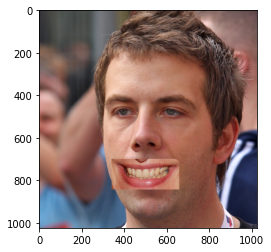

In [25]:
parser = argparse.ArgumentParser(description='The demo of still image of 3DDFA_V2')
parser.add_argument('-c', '--config', type=str, default='configs/mb1_120x120.yml')
parser.add_argument('-f', '--img_fp', type=str, default='examples/inputs/trump_hillary.jpg')
parser.add_argument('-r', '--video_root_path', type=str, default='/home/uss00067/Datasets/MEAD_Frames')
parser.add_argument('-s', '--video_save_path', type=str, default='/home/uss00067/Datasets/FDC')
parser.add_argument('-m', '--mode', type=str, default='cpu', help='gpu or cpu mode')
parser.add_argument('-o', '--opt', type=str, default='2d_sparse',
                    choices=['2d_sparse', '2d_dense', '3d', 'depth', 'pncc', 'uv_tex', 'pose', 'ply', 'obj'])
parser.add_argument('--show_flag', type=str2bool, default='true', help='whether to show the visualization result')
parser.add_argument('--onnx', action='store_true', default=False)

args = parser.parse_args()
main(args)